In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
df = pd.read_csv('../data/application_train.csv')

# Overview
print(f"Shape: {df.shape}")
df.head()

Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info() # datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
# Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percentage = (missing / df.shape[0]) * 100 #percentage of missing data
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percentage}) #combine into a new df

missing_df

,Missing Count,Missing %
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
...,...,...
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


In [8]:
# droping columns with alot of missing data
df = df.drop(columns=missing_df[missing_df['Missing %'] > 40].index)

# Impute remaining missing values
df.fillna(df.median(numeric_only=True), inplace=True)


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
# Info and data types
df.info()

# Describe numeric features
df.describe()

# Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percentage = (missing / df.shape[0]) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percentage})
missing_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307511 non-null  float64
 10  AMT_GOODS_PRICE              307511 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

,Missing Count,Missing %
OCCUPATION_TYPE,96391,31.345545
NAME_TYPE_SUITE,1292,0.420148


In [11]:
# Drop columns with too much missing data (e.g. >40%)
df = df.drop(columns=missing_df[missing_df['Missing %'] > 40].index)

#df.fillna(df.median(numeric_only=True), inplace=True)


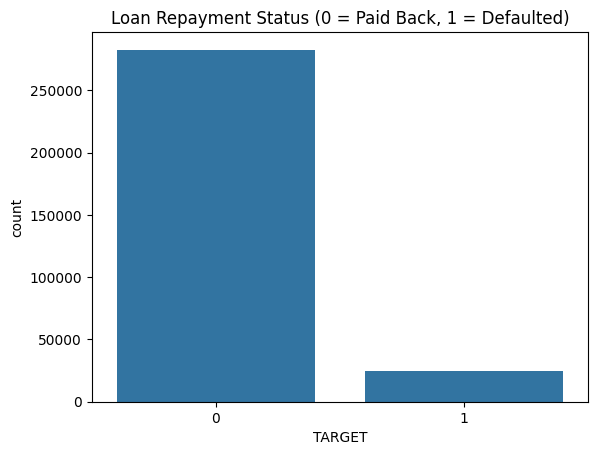

,proportion
TARGET,
0,0.919271
1,0.080729


In [12]:
# Distribution of TARGET
sns.countplot(data=df, x='TARGET')
plt.title('Loan Repayment Status (0 = Paid Back, 1 = Defaulted)')
plt.show()

# Proportions
df['TARGET'].value_counts(normalize=True)


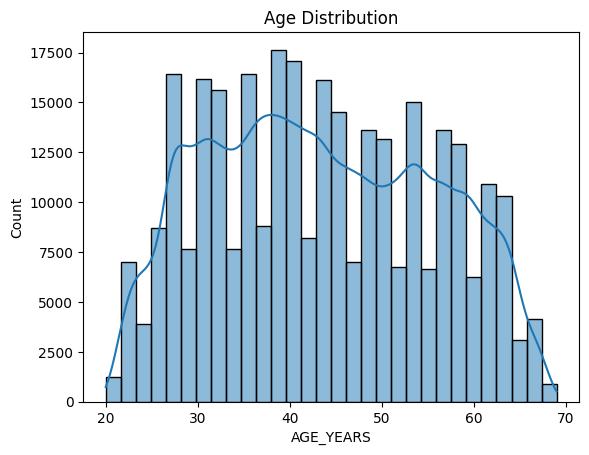

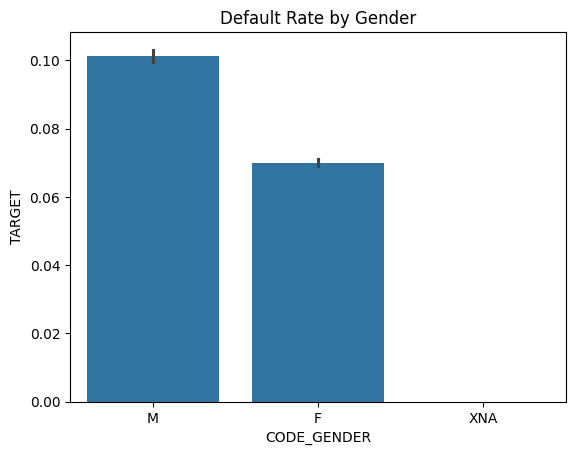

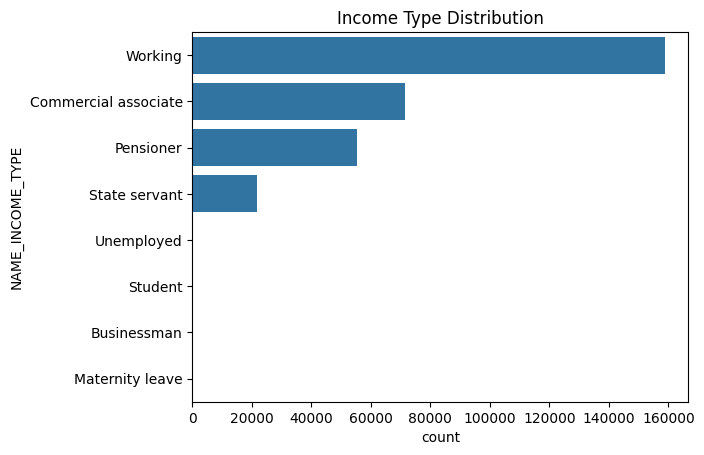

In [13]:
# Age (from DAYS_BIRTH)
df['AGE_YEARS'] = abs(df['DAYS_BIRTH']) // 365
sns.histplot(df['AGE_YEARS'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Gender vs Default Rate
sns.barplot(data=df, x='CODE_GENDER', y='TARGET')
plt.title('Default Rate by Gender')
plt.show()

# Income Type
sns.countplot(data=df, y='NAME_INCOME_TYPE', order=df['NAME_INCOME_TYPE'].value_counts().index)
plt.title('Income Type Distribution')
plt.show()


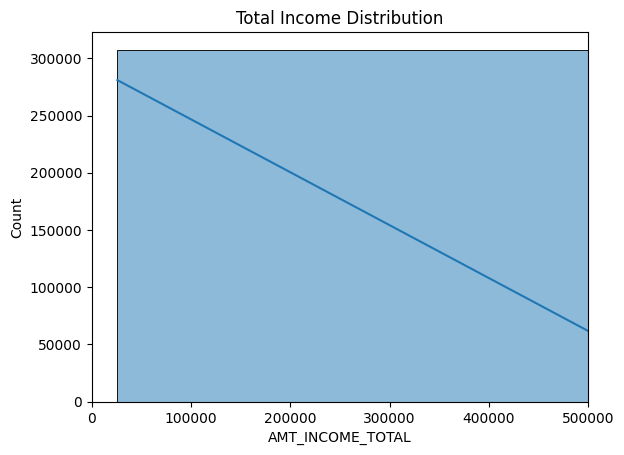

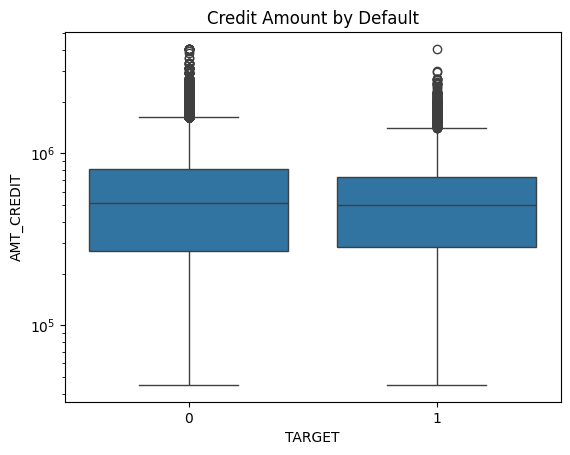

In [14]:
# Income distribution
sns.histplot(df['AMT_INCOME_TOTAL'], bins=50, kde=True)
plt.xlim(0, 500000)
plt.title('Total Income Distribution')
plt.show()

# Credit amount vs Default
sns.boxplot(data=df, x='TARGET', y='AMT_CREDIT')
plt.yscale('log')
plt.title('Credit Amount by Default')
plt.show()


In [15]:
print(df.columns.tolist())


['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FL

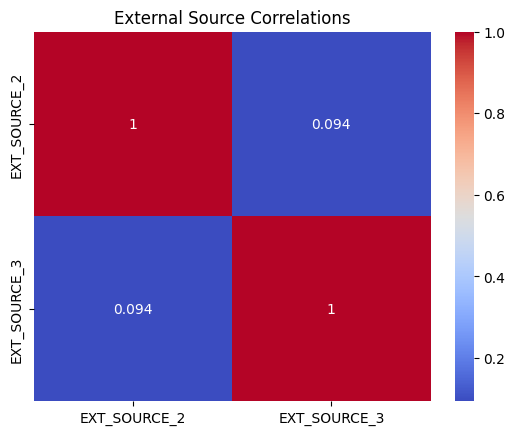

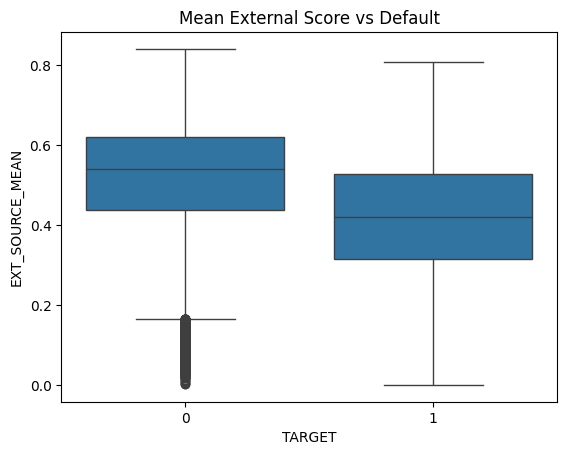

In [16]:
ext_sources = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
available_ext_sources = [col for col in ext_sources if col in df.columns]

if available_ext_sources:
    sns.heatmap(df[available_ext_sources].corr(), annot=True, cmap='coolwarm')
    plt.title('External Source Correlations')
    plt.show()

    df['EXT_SOURCE_MEAN'] = df[available_ext_sources].mean(axis=1)

    sns.boxplot(data=df, x='TARGET', y='EXT_SOURCE_MEAN')
    plt.title('Mean External Score vs Default')
    plt.show()
else:
    print("No EXT_SOURCE columns found in the dataset.")


In [17]:
# Correlation with TARGET
correlations = df.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)
correlations.head(15), correlations.tail(15)


(TARGET                         1.000000
 DAYS_BIRTH                     0.078239
 REGION_RATING_CLIENT_W_CITY    0.060893
 REGION_RATING_CLIENT           0.058899
 DAYS_LAST_PHONE_CHANGE         0.055218
 DAYS_ID_PUBLISH                0.051457
 REG_CITY_NOT_WORK_CITY         0.050994
 FLAG_EMP_PHONE                 0.045982
 REG_CITY_NOT_LIVE_CITY         0.044395
 FLAG_DOCUMENT_3                0.044346
 DAYS_REGISTRATION              0.041975
 LIVE_CITY_NOT_WORK_CITY        0.032518
 DEF_30_CNT_SOCIAL_CIRCLE       0.032394
 DEF_60_CNT_SOCIAL_CIRCLE       0.031401
 FLAG_WORK_PHONE                0.028524
 Name: TARGET, dtype: float64,
 FLAG_DOCUMENT_13             -0.011583
 FLAG_DOCUMENT_16             -0.011615
 AMT_ANNUITY                  -0.012815
 AMT_REQ_CREDIT_BUREAU_MON    -0.014794
 FLAG_PHONE                   -0.023806
 HOUR_APPR_PROCESS_START      -0.024166
 FLAG_DOCUMENT_6              -0.028602
 AMT_CREDIT                   -0.030369
 REGION_POPULATION_RELATIVE   -0.0

In [18]:
# Get numeric features only
numeric_df = df.select_dtypes(include=[np.number])

# Correlation of all features with TARGET
correlation_with_target = numeric_df.corr()['TARGET'].sort_values(ascending=False)

# Show strongest positive and negative correlations
print("Top Positive Correlations:")
print(correlation_with_target.head(10))

print("\nTop Negative Correlations:")
print(correlation_with_target.tail(10))


Top Positive Correlations:
TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

Top Negative Correlations:
HOUR_APPR_PROCESS_START      -0.024166
FLAG_DOCUMENT_6              -0.028602
AMT_CREDIT                   -0.030369
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039623
DAYS_EMPLOYED                -0.044932
AGE_YEARS                    -0.078234
EXT_SOURCE_3                 -0.155892
EXT_SOURCE_2                 -0.160295
EXT_SOURCE_MEAN              -0.213701
Name: TARGET, dtype: float64


In [19]:
# Strip whitespace and convert to uppercase for consistency
df.columns = df.columns.str.strip().str.upper()


In [20]:
# KITNI ROWS KAI PASS 1000 YEARS AHIN??? BECASUE THSI ISNT REALISTIC DUMMY HAI DUMB
print((df['DAYS_EMPLOYED'] == 365243).sum())

df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


55374


/tmp/ipython-input-20-3565658660.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


In [21]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'])
df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'])


In [22]:
# Check data types
df.dtypes.value_counts()

# Convert to category where appropriate
for col in df.select_dtypes('object').columns:
    if df[col].nunique() < 10:  # low cardinality
        df[col] = df[col].astype('category')


In [23]:
df.drop(columns=['SK_ID_CURR'], inplace=True)


In [24]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percentage = (missing / df.shape[0]) * 100

missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percentage})
missing_df


,Missing Count,Missing %
OCCUPATION_TYPE,96391,31.345545
DAYS_EMPLOYED,55374,18.007161
NAME_TYPE_SUITE,1292,0.420148


In [25]:
# Fill remaining NaNs with median (for numeric)
#df.fillna(df.median(numeric_only=True), inplace=True)


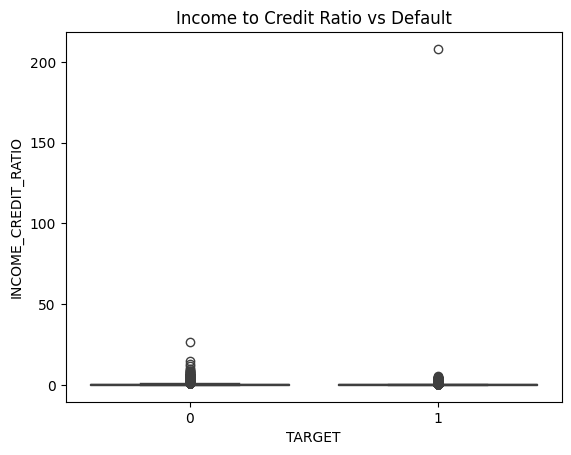

In [26]:
# Income to credit ratio
df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

# Annuity to income ratio
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Employment to age ratio
df['EMPLOYED_TO_AGE'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

# Explore how these new features relate to target
sns.boxplot(data=df, x='TARGET', y='INCOME_CREDIT_RATIO')
plt.title("Income to Credit Ratio vs Default")
plt.show()


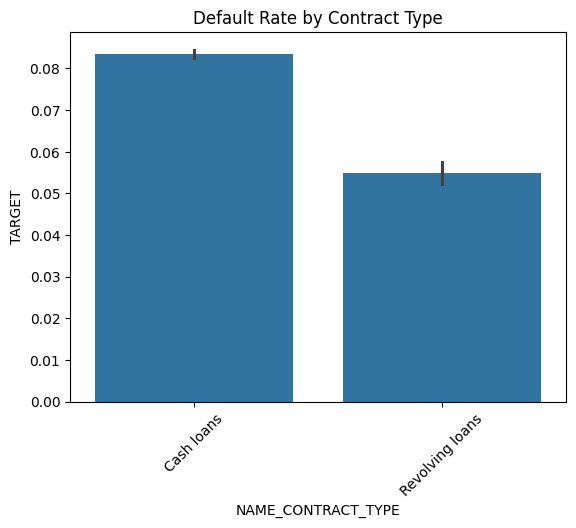

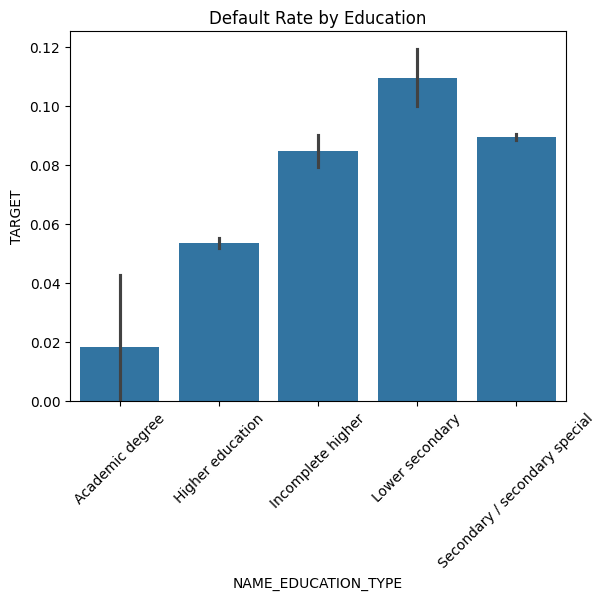

In [27]:
# Barplot of default rate by contract type
sns.barplot(data=df, x='NAME_CONTRACT_TYPE', y='TARGET')
plt.title("Default Rate by Contract Type")
plt.xticks(rotation=45)
plt.show()

# Default rate by education type
sns.barplot(data=df, x='NAME_EDUCATION_TYPE', y='TARGET')
plt.title("Default Rate by Education")
plt.xticks(rotation=45)
plt.show()


In [28]:
# Label encode binary categoricals
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])

# One-hot encode the rest
df = pd.get_dummies(df, drop_first=True)


In [29]:
# Fill remaining nulls with median
#df.fillna(df.median(numeric_only=True), inplace=True)


In [30]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
num_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'INCOME_CREDIT_RATIO'
]


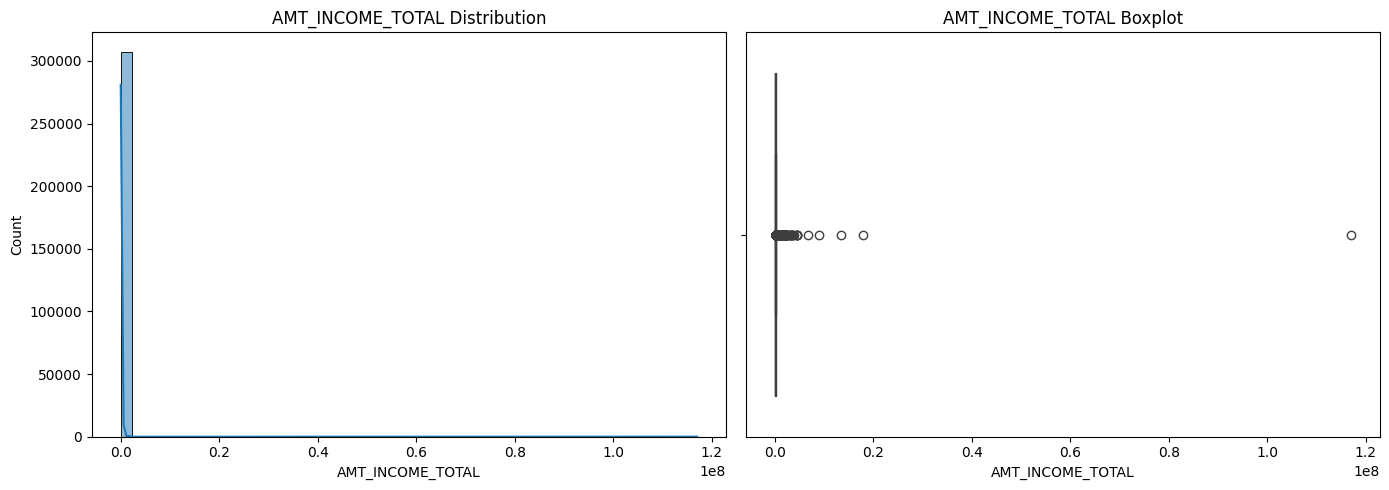

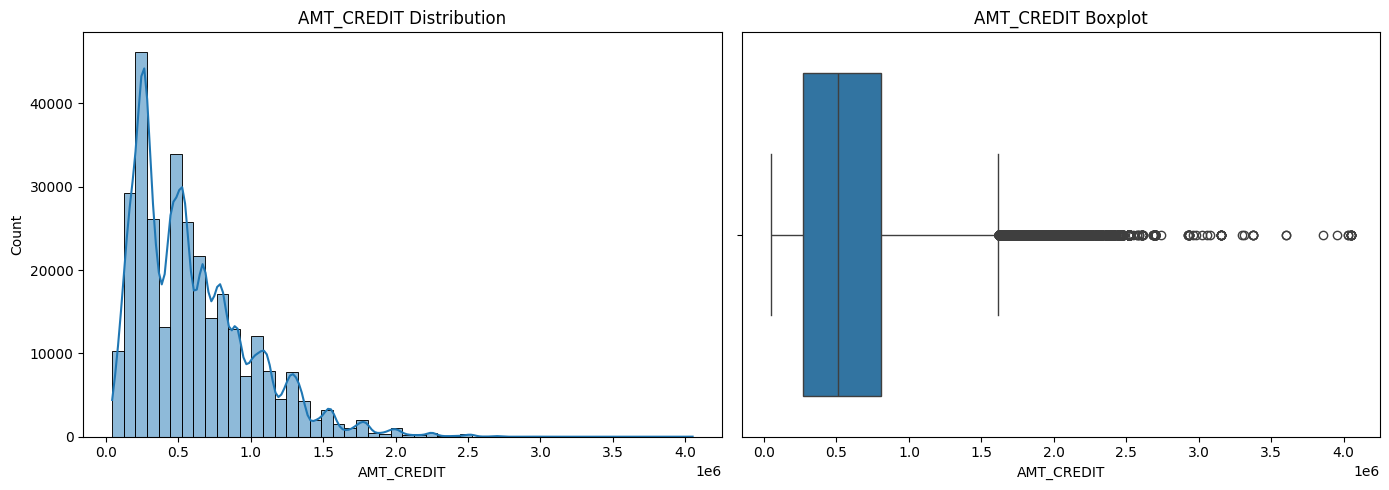

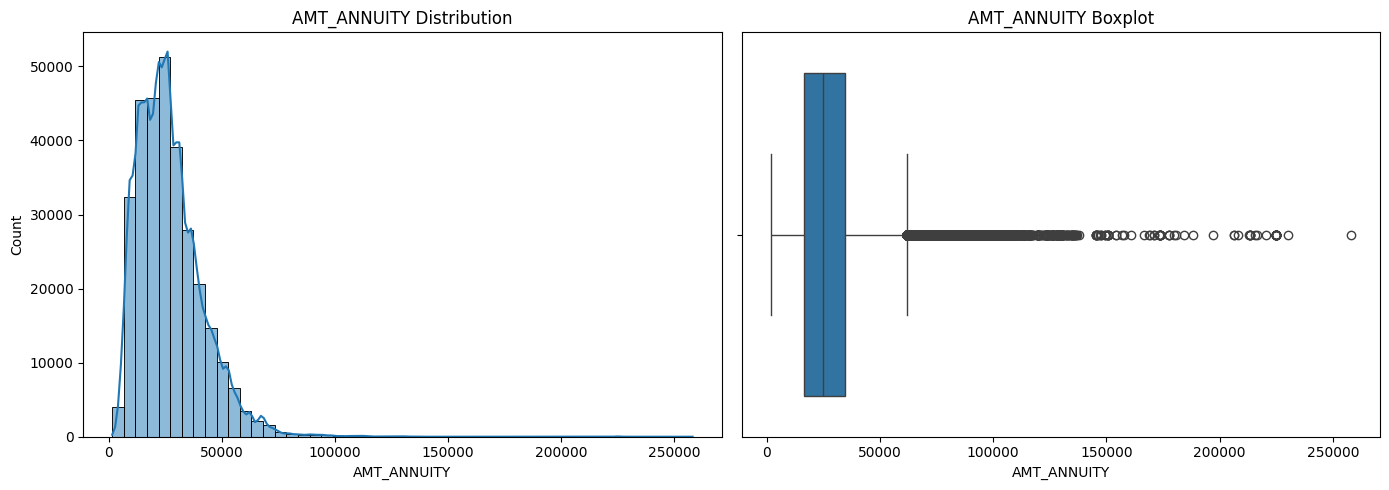

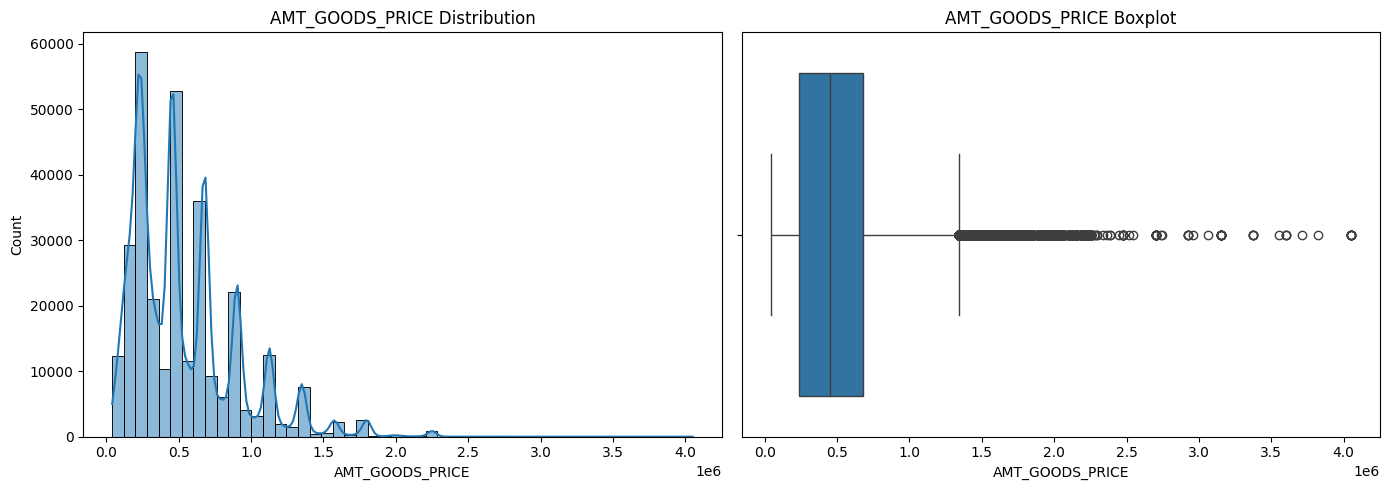

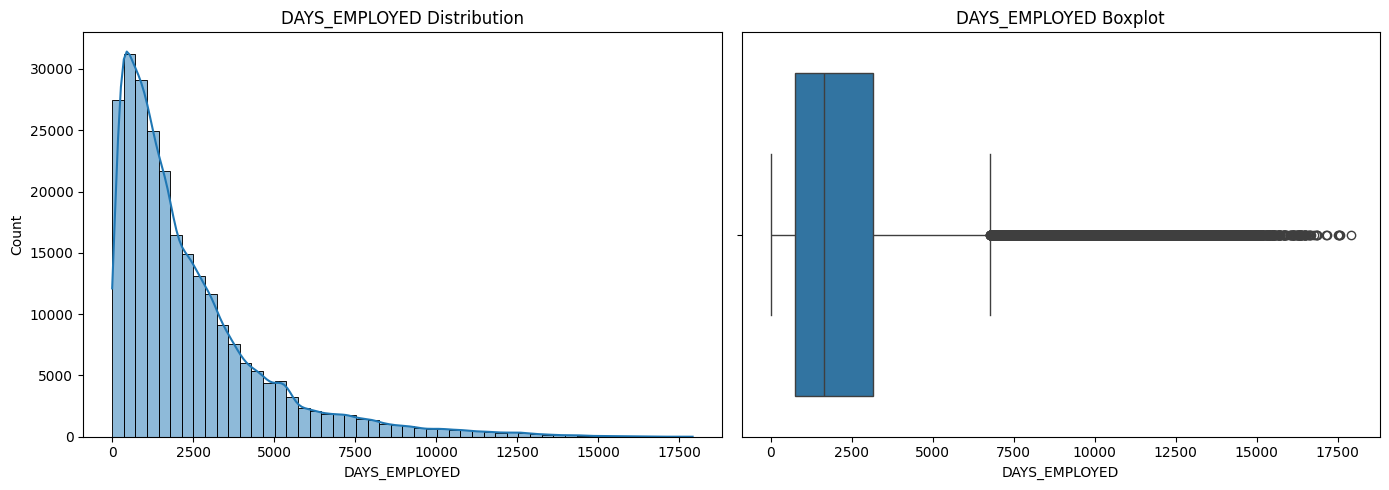

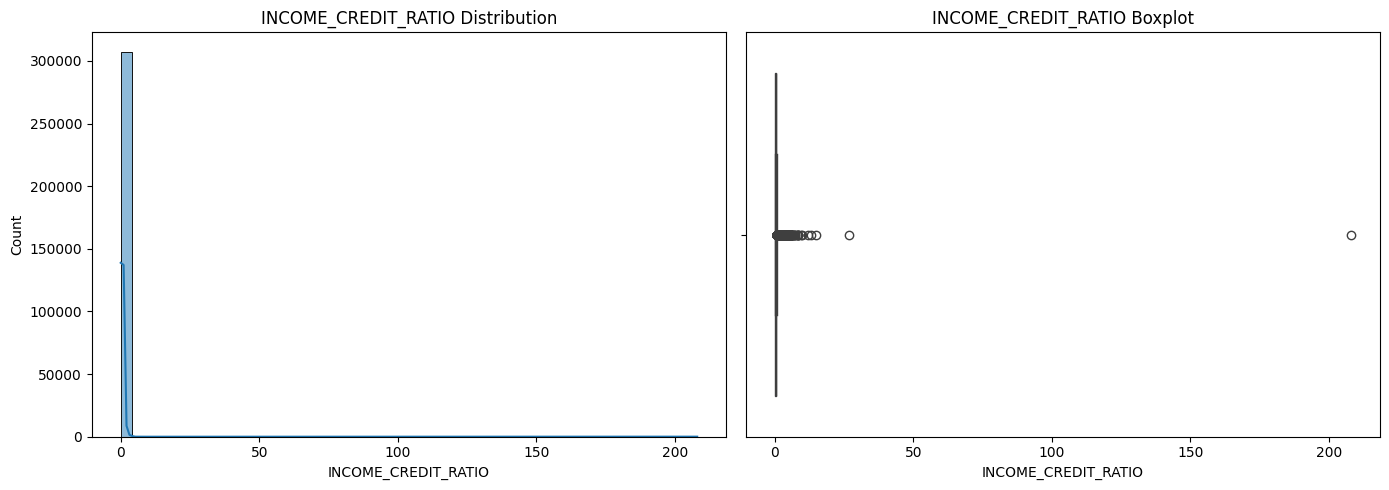

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in num_features:
    plt.figure(figsize=(14, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f'{feature} Distribution')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'{feature} Boxplot')

    plt.tight_layout()
    plt.show()


In [33]:
for feature in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']:
    df[f'LOG_{feature}'] = np.log1p(df[feature])


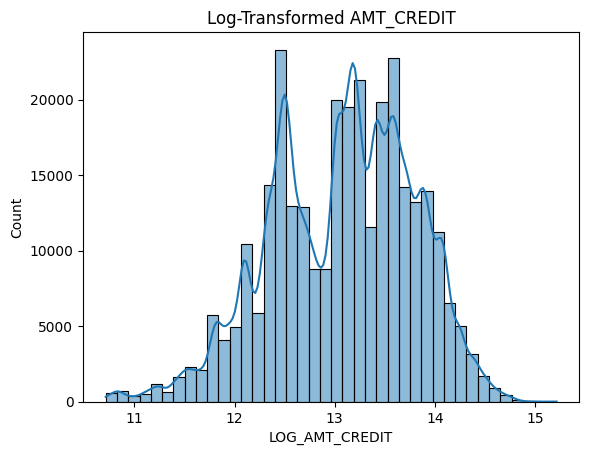

In [34]:
sns.histplot(df['LOG_AMT_CREDIT'], bins=40, kde=True)
plt.title('Log-Transformed AMT_CREDIT')
plt.show()


In [35]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns only (excluding TARGET)
num_cols = df.select_dtypes(include=[np.number]).columns.drop('TARGET')

# Initialize and apply scaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [36]:
df[num_cols].describe().T[['mean', 'std']].head(10)


,mean,std
CNT_CHILDREN,-3.207148e-17,1.000002
AMT_INCOME_TOTAL,-1.590866e-17,1.000002
AMT_CREDIT,-4.074788e-17,1.000002
AMT_ANNUITY,-1.732969e-17,1.000002
AMT_GOODS_PRICE,2.021797e-18,1.000002
REGION_POPULATION_RELATIVE,1.592599e-16,1.000002
DAYS_BIRTH,-3.364271e-17,1.000002
DAYS_EMPLOYED,1.108915e-17,1.000002
DAYS_REGISTRATION,-6.100051e-18,1.000002
DAYS_ID_PUBLISH,6.732007e-17,1.000002


In [37]:
df_scaled = df.copy()  # USE THIS ONE FOR MODELIGNG BECAUSE COPY AND ORGINIAL SAVE DUMB


In [38]:
# Model Building Starts Here

# --- IGNORE ---

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Split features and target
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 60/20/20 split

# Initialize and train the model
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Predict again
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)



In [40]:
# Initial model evaluation

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.8553868166888882
ROC-AUC: 0.5369664112187633

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     56485
           1       0.14      0.16      0.15      5017

    accuracy                           0.86     61502
   macro avg       0.53      0.54      0.54     61502
weighted avg       0.86      0.86      0.86     61502

Confusion Matrix:
 [[51823  4662]
 [ 4232   785]]

Test Set Metrics:
Accuracy: 0.8576492203632343
ROC-AUC: 0.5392725626691972

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     56554
           1       0.15      0.16      0.15      4949

    accuracy                           0.86     61503
   macro avg       0.54      0.54      0.54     61503
weighted avg       0.86      0.86      0.86     61503

Confusion Matrix:
 [[51957  4597]
 [ 4158   791]]


The model is not performing well for the minority class (Class 1). The high accuracy is deceptive due to the highly imbalanced dataset.

Basically, the model is effectively failing to correctly classify the minority class (Class 1).

So trying to apply oversampling to the minority class through SMOTE

In [42]:
# Using GridSearch to find the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='roc_auc', verbose=1)

In [43]:
# best one
best_dt = grid_search.best_estimator_

# Predict
y_val_pred = best_dt.predict(X_val)
y_test_pred = best_dt.predict(X_test)


In [44]:
# Initial model evaluation

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.6668563623947189
ROC-AUC: 0.6588998043987787

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79     56485
           1       0.15      0.65      0.24      5017

    accuracy                           0.67     61502
   macro avg       0.55      0.66      0.51     61502
weighted avg       0.89      0.67      0.74     61502

Confusion Matrix:
 [[37755 18730]
 [ 1759  3258]]

Test Set Metrics:
Accuracy: 0.6671869664894395
ROC-AUC: 0.6607421622678847

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79     56554
           1       0.15      0.65      0.24      4949

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.74     61503

Confusion Matrix:
 [[37802 18752]
 [ 1717  3232]]


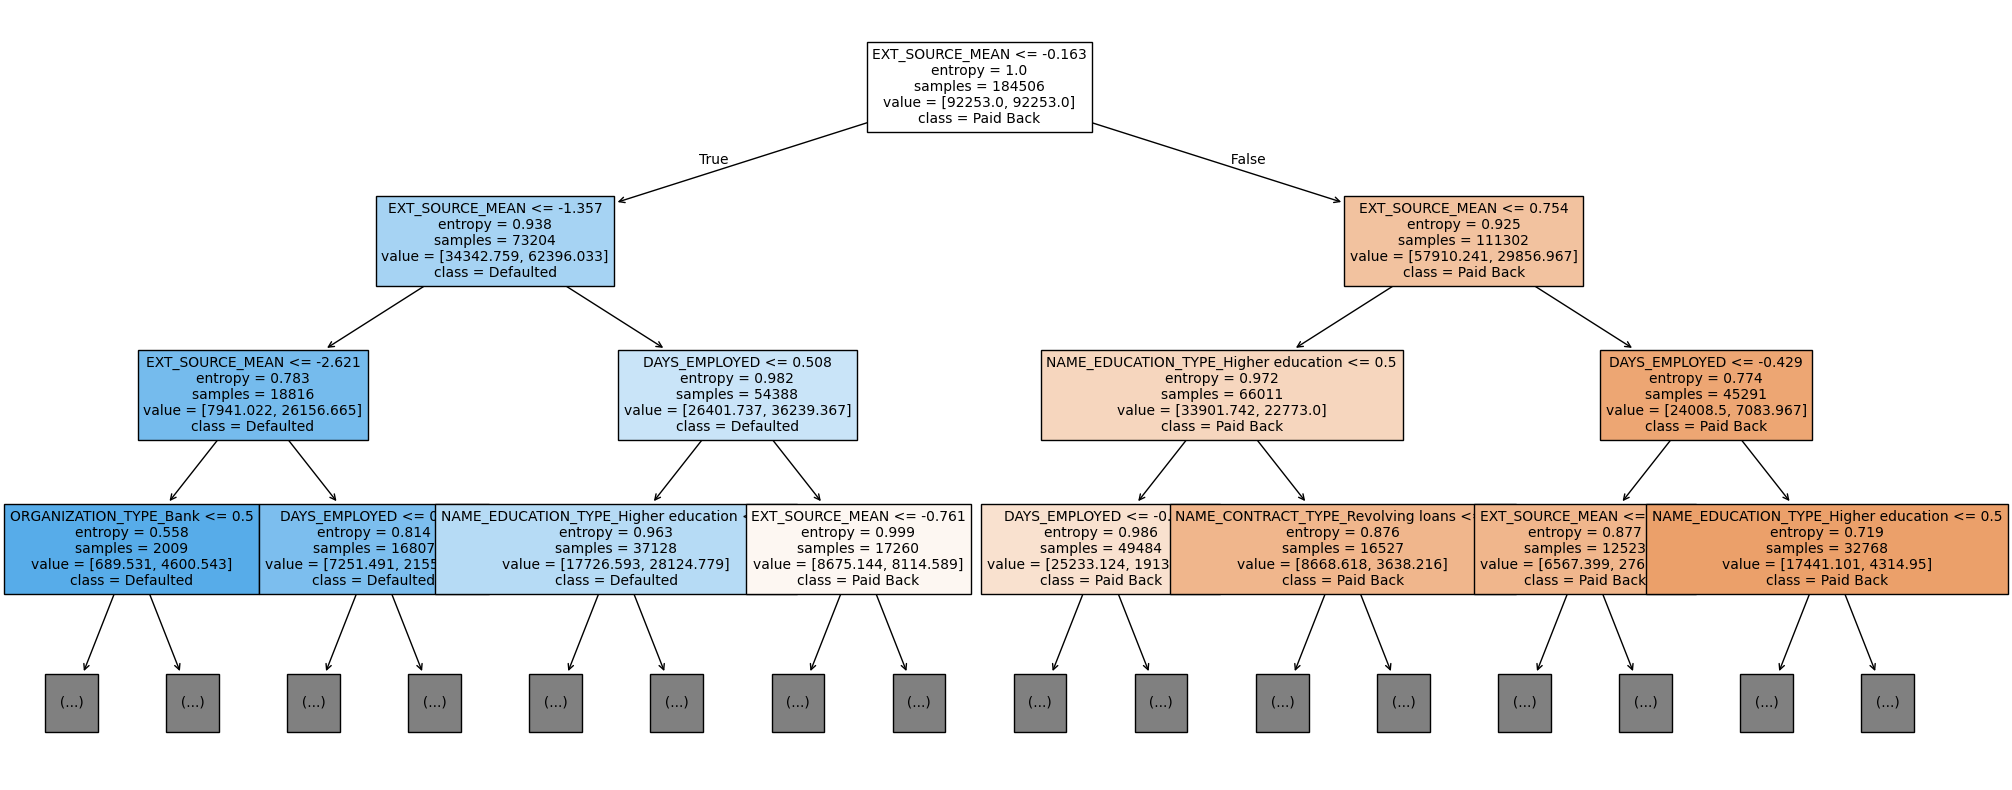

In [45]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plot_tree(best_dt,
          feature_names=X_val.columns,
          class_names=['Paid Back', 'Defaulted'],
          filled=True,
          max_depth=3,   # Show only top levels
          fontsize=10)
plt.show()


In [46]:
# Saving model through pickle library
import pickle

with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(best_dt, f)


In [47]:
# Trying other models now
#
#

Validation Set Metrics:
Accuracy: 0.9184579363272739
ROC-AUC: 0.5014706517271215

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56485
           1       0.53      0.00      0.01      5017

    accuracy                           0.92     61502
   macro avg       0.73      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502

Confusion Matrix:
 [[56471    14]
 [ 5001    16]]

Test Set Metrics:
Accuracy: 0.9196461961205145
ROC-AUC: 0.5014447288073042

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.65      0.00      0.01      4949

    accuracy                           0.92     61503
   macro avg       0.79      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

Confusion Matrix:
 [[56546     8]
 [ 4934    15]]


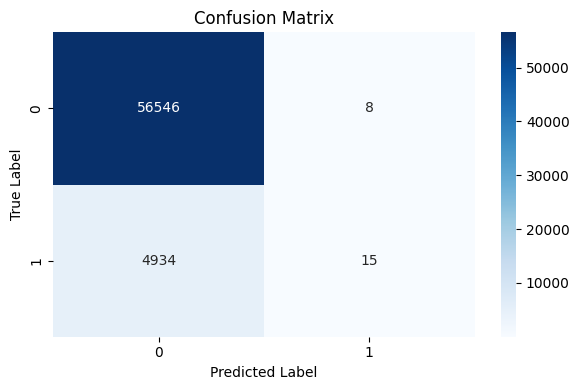

In [48]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("===================================================")

**Random Forest shows high overall accuracy (~92%) but performs poorly on class 1, with near-zero recall and ROC-AUC ≈ 0.5, indicating it's essentially guessing for that class. This suggests severe class imbalance and poor generalization for minority class predictions.**

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Impute missing values in training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_imputed, y_train)

y_val_pred = lr.predict(X_val_imputed)
y_test_pred = lr.predict(X_test_imputed)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")


Validation Set Metrics:
Accuracy: 0.6864329615297063
ROC-AUC: 0.6756417205137127

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56485
           1       0.16      0.66      0.26      5017

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.89      0.69      0.76     61502

Confusion Matrix:
 [[38892 17593]
 [ 1692  3325]]

Test Set Metrics:
Accuracy: 0.6864055411931125
ROC-AUC: 0.6789362613700235

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.67      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

Confusion Matrix:
 [[38900 17654]
 [ 1633  3316]]


**The logistic regression model improved recall for class 1 (66%), addressing the imbalance issue. However, overall accuracy dropped (69%) and precision for class 1 is still low (16%), meaning many false positives. ROC-AUC (0.67) shows moderate discrimination ability.**

In [50]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    scale_pos_weight=11.4,  # ~ ratio of class 0 / class 1
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

y_val_pred = xgb.predict(X_val)
y_test_pred = xgb.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Set Metrics:
Accuracy: 0.7336509381808721
ROC-AUC: 0.6661136732789317

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84     56485
           1       0.17      0.59      0.26      5017

    accuracy                           0.73     61502
   macro avg       0.56      0.67      0.55     61502
weighted avg       0.89      0.73      0.79     61502

Confusion Matrix:
 [[42184 14301]
 [ 2080  2937]]

Test Set Metrics:
Accuracy: 0.7352324276864544
ROC-AUC: 0.6728510586602006

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84     56554
           1       0.17      0.60      0.27      4949

    accuracy                           0.74     61503
   macro avg       0.56      0.67      0.55     61503
weighted avg       0.89      0.74      0.79     61503

Confusion Matrix:
 [[42257 14297]
 [ 1987  2962]]


**XGB Classifier:**

Accuracy improved to 74%; ROC-AUC ~0.67 shows moderate separation.

Class 1 recall is 60%, but precision remains low (~17%) — many false positives.

Overall, better at identifying class 1 than before, but still imbalanced in prediction quality.

In [51]:
# FINAL OVERVIEW

"""
The XGB classifier model (Accuracy ~74%, Class 1 recall ~60%, Precision ~17%) is the best overall, having higher accuracy than others, with a
balanced recall for class 1 with moderate false positives. The ROC-AUC score of ~0.67 is similar across all models, but here the model has
better overall performance metrics.
"""

' \nThe XGB classifier model (Accuracy ~74%, Class 1 recall ~60%, Precision ~17%) is the best overall, having higher accuracy than others, with a\nbalanced recall for class 1 with moderate false positives. The ROC-AUC score of ~0.67 is similar across all models, but here the model has\nbetter overall performance metrics.\n'